In [5]:
import requests
import pandas as pd
import numpy as np
import io
import json

## Credentials
The necessary input is own system id (sid) + API key  
Note again that getting data from other systems through PVoutput's API is dependent on an API key only available through the donation program

In [6]:
# Only run if key in separate json file
with open('key.txt') as json_file:
    credentials = json.load(json_file)    
    

In [25]:
# Run in case key pasted here directly
sid_personal = '<PERSONAL SID HERE'
pvoutput_key = '<KEY HERE>'

credentials = {'sid_personal': sid_personal, 'pvoutput_key': pvoutput_key}

## Request  
payload possibilities to pvoutput are given at https://pvoutput.org/help.html#api-getstatus.  
To get all values for a desired day, history needs to be enabled and a limit large enough needs to be given.  
A request to the API itself is always for a single day. 
A day can be 25 hours probably, with 5 minute increments between data points, this equates to 300 data points.
<br>
<br>

Example sid(1)'s:  
sid_varjusolar (Hungary) = '27781'  
sid_deVries (NL) = '60328'  https://pvoutput.org/list.jsp?id=67874&sid=60328  

In [62]:
def RequestPVoutput(sid1, Date = None):
    # No specified date results in today's data
    pvoutput_service_url = 'https://pvoutput.org/service/r2/getstatus.jsp'
    
    history = 1
    limit = 500

    payload = {'sid': credentials['sid_personal'], 
               'key': credentials['pvoutput_key'], 
               'sid1': str(sid1), 
               'h': history,
               'limit': limit
              }
    if Date:
        payload['d'] = Date.strftime('%Y%m%d')
    
    r = requests.get(pvoutput_service_url, params=payload)
    print(f'Status code {r.status_code} -- {Date} GOT')
    
    return r


def ParsePVoutput(RequestsResponse):
    pvoutputFields = ['Date', 'Time', 'DayGeneration', 'DayEfficiency', 'Power', 'Average', 'Normalised', 'Unknown1', 'Unknown2', 'Unknown3', 'Unknown4']

    urlData = RequestsResponse.content
    urlData = urlData.decode('utf-8').replace(';', '\n')
    df_solar = pd.read_csv(io.StringIO(urlData), names = pvoutputFields, )
    df_solar['Date'] = df_solar['Date'].astype(str) + ' ' + df_solar['Time']
    df_solar['Date'] = pd.to_datetime(df_solar['Date'], format= '%Y%m%d %H:%M')

    df_solar.drop(['Time'], axis=1, inplace= True)
    df_solar.set_index('Date', inplace= True)

    df_solar = df_solar[pvoutputFields[2:7]]
    return df_solar


# Single day request 

In [63]:
r = RequestPVoutput(sid1= '60328', Date = pd.to_datetime('2020-02-15'))

df_solar = ParsePVoutput(RequestsResponse= r)
df_solar

Status code 200 -- 2020-02-15 00:00:00 GOT


,DayGeneration,DayEfficiency,Power,Average,Normalised
Date,,,,,
2020-02-15 23:55:00,2679.0,0.523,0,0.0,0.0
2020-02-15 23:50:00,2679.0,0.523,0,0.0,0.0
2020-02-15 23:45:00,2679.0,0.523,0,0.0,0.0
2020-02-15 23:40:00,2679.0,0.523,0,0.0,0.0
2020-02-15 23:35:00,2679.0,0.523,0,0.0,0.0
...,...,...,...,...,...
2020-02-15 00:20:00,NaN,NaN,0,NaN,NaN
2020-02-15 00:15:00,NaN,NaN,0,NaN,NaN
2020-02-15 00:10:00,NaN,NaN,0,NaN,NaN


# Multi-day dataframe 

In [64]:
df = pd.DataFrame()
for date in pd.date_range(start='2020-01-12', end='2020-01-13'):
    r = RequestPVoutput(sid1= '60328', Date= date)
    
    df_solar = ParsePVoutput(RequestsResponse= r)
    df = df.append(df_solar)
    
df.sort_index(inplace= True)

Status code 200 -- 2020-01-12 00:00:00 GOT
Status code 200 -- 2020-01-13 00:00:00 GOT


In [65]:
df

,DayGeneration,DayEfficiency,Power,Average,Normalised
Date,,,,,
2020-01-12 00:00:00,NaN,NaN,0,NaN,NaN
2020-01-12 00:05:00,NaN,NaN,0,NaN,NaN
2020-01-12 00:10:00,NaN,NaN,0,NaN,NaN
2020-01-12 00:15:00,NaN,NaN,0,NaN,NaN
2020-01-12 00:20:00,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...
2020-01-13 23:35:00,2898.0,0.566,0,0.0,0.0
2020-01-13 23:40:00,2898.0,0.566,0,0.0,0.0
2020-01-13 23:45:00,2898.0,0.566,0,0.0,0.0


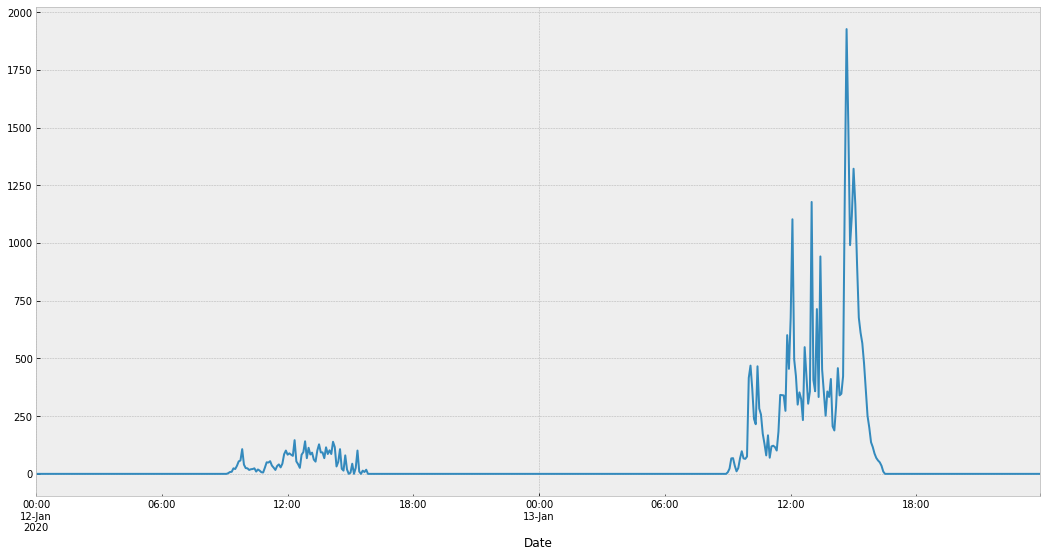

In [66]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

fig,ax = plt.subplots(figsize= (18, 9))

df['Power'].plot(ax= ax)